# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import pickle
import re

In [3]:
reading_f = open("philly.pickle", 'rb')

# Load Pickle files

In [4]:
class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
            self._computation_time = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
            computation_time = 0.0
            for attempt in self._attempts:
                if attempt['start_time'] is not None and attempt['end_time'] is not None:
                    computation_time += timedelta_to_minutes(attempt['end_time'] -
                                                             attempt['start_time'])
                else:
                    computation_time = None
                    break
            self._computation_time = computation_time
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time
    
    @property
    def computation_time(self):
        return self._computation_time

In [5]:
with open("philly.pickle", 'rb') as f:
    jobs = pickle.load(f)
    active_jobs_per_boundary = pickle.load(f)
    all_boundaries = pickle.load(f)
    latest_completion_time = pickle.load(f)
    num_jobs_per_boundary = pickle.load(f)

# Plot trace in different ways

In [6]:
LOGDIR = '../trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [7]:
lower_bound = 4500
upper_bound = 5000

earliest_arrival_time = jobs[0].submitted_time

active_steady_state_jobs = set()
for i in range(lower_bound, upper_bound):
    active_steady_state_jobs = active_steady_state_jobs.union(active_jobs_per_boundary[i])
active_steady_state_jobs = sorted(active_steady_state_jobs)

In [8]:
jobs_to_complete = set()
jobs_to_complete_duration = list()
jobs_to_complete_num_gpus = list()
for i, idx in enumerate(active_steady_state_jobs):
    job = jobs[idx]
    start_time = timedelta_to_minutes(job.submitted_time - earliest_arrival_time) * 60.0 # seconds
    end_time = None
    for j in range(len(job.attempts)-1, 0, -1):
        if job.attempts[j]['end_time'] is not None:
            end_time = timedelta_to_minutes(job.attempts[j]['end_time'] - earliest_arrival_time) * 60.0 # seconds
            break
    if end_time is None:
        continue
    if start_time >= all_boundaries[lower_bound] and end_time <= all_boundaries[upper_bound-1] and job.run_time < 3000:
        jobs_to_complete.add(i)
        jobs_to_complete_duration.append(job.run_time)
        jobs_to_complete_num_gpus.append(job.num_gpus)

(0, 3163.65)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


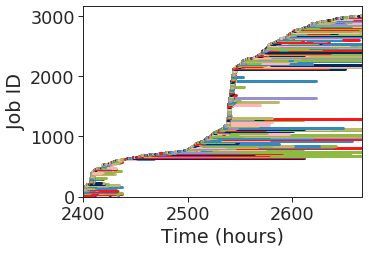

In [9]:
plt.figure(figsize=(5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
jobs_duration = []
jobs_num_gpus = []
for i, idx in enumerate(active_steady_state_jobs):
    jobs_duration.append(jobs[idx].run_time)
    jobs_num_gpus.append(jobs[idx].num_gpus)
    start_time_in_seconds = timedelta_to_minutes(jobs[idx].submitted_time - earliest_arrival_time) * 60.0
    end_time_in_seconds = timedelta_to_minutes(jobs[idx].attempts[-1]['end_time'] - earliest_arrival_time) * 60.0
    ax.plot([start_time_in_seconds / 3600.,
             end_time_in_seconds / 3600.],
             [i, i])
jobs_duration = jobs_duration[1:]
jobs_num_gpus = jobs_num_gpus[1:]
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Job ID")
ax.set_xlim([all_boundaries[lower_bound] / 3600.,
             all_boundaries[upper_bound] / 3600.])
ax.set_ylim([0, None])

Text(0, 0.5, 'Job Runtime\n(minutes)')

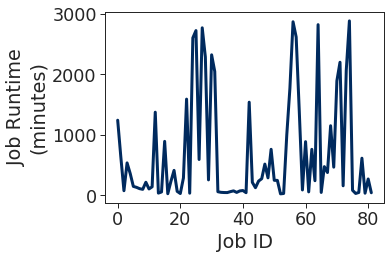

In [10]:
x = range(len(jobs_to_complete_duration))
y = jobs_to_complete_duration
plt.figure(figsize=(5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(x, y)
ax.set_xlabel('Job ID')
ax.set_ylabel('Job Runtime\n(minutes)')

Text(0, 0.5, 'Duration\n(minutes)')

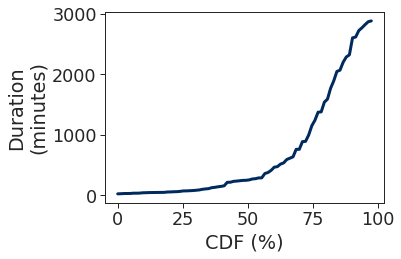

In [11]:
x = (np.array(range(len(jobs_to_complete_duration))) / \
    (len(jobs_to_complete_duration) + 1)) * 100.0
y = sorted(jobs_to_complete_duration)
plt.figure(figsize=(5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(x, y)
ax.set_xlabel('CDF (%)')
ax.set_ylabel('Duration\n(minutes)')

Text(0, 0.5, 'Number of GPUs')

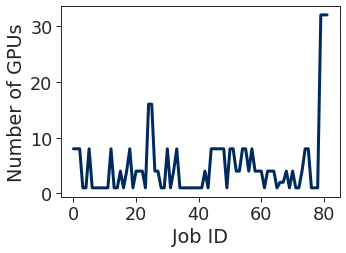

In [12]:
x = range(len(jobs_to_complete_num_gpus))
y = jobs_to_complete_num_gpus
plt.figure(figsize=(5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(x, y)
ax.set_xlabel('Job ID')
ax.set_ylabel('Number of GPUs')

Text(0, 0.5, 'Number of GPUs')

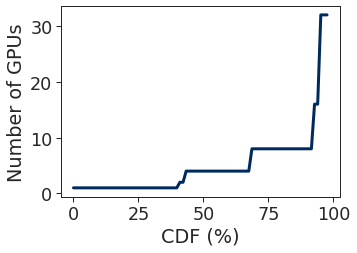

In [13]:
x = (np.array(range(len(jobs_to_complete_duration))) / \
    (len(jobs_to_complete_duration) + 1)) * 100.0
y = sorted(jobs_to_complete_num_gpus)
plt.figure(figsize=(5, 3.5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
ax.plot(x, y)
ax.set_xlabel('CDF (%)')
ax.set_ylabel('Number of GPUs')